### Pig grunts audio classification

In [1]:
import torch
import torchaudio
import IPython
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from torch import nn
from torchsummary import summary
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.model_selection import train_test_split, KFold
from pprint import pprint
from collections import defaultdict



#from torchvision import transforms


from model_v2 import *
from functions import *


print(torch.__version__)
print(torchaudio.__version__)

2.1.0
2.1.0


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# set all the parameters

data_path = os.path.join(os.getcwd(), 'Dataset')

fixed_sample_rate = 48000 #16000
num_samples = 98000 #16000
n_fft = 1024 #512 #1024
hop_length = 512
n_mels = 60 #64
n_mfcc = 60


transfo_mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=fixed_sample_rate,
        n_fft=n_fft,
        normalized=True,
        hop_length=hop_length,
        n_mels=n_mels,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        mel_scale="htk")

transfo_mfcc = torchaudio.transforms.MFCC(
        sample_rate=fixed_sample_rate,
        n_mfcc=n_mfcc,
        dct_type=2,
        norm='ortho',
        log_mels=False)

transfo_spectro = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        hop_length = hop_length,
        power=2.0,
        normalized=False,
        center=True,
        pad_mode='reflect',
        onesided=True,
        return_complex=None)

C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [5]:
# choose which transformation to apply to the waveforms + adjust necessary parameters/variables :

transfo_applied = 'spectrogram'
# transfo_applied = 'mel_spectrogram'
# transfo_applied = 'mfcc'


if transfo_applied == 'spectrogram':
    transformation = transfo_spectro
    cnn = CNN_spectro()
    best_model = CNN_spectro()
    random_tensor = torch.rand([64,1,513,192]).to(device)

elif transfo_applied == 'mel_spectrogram' :
    transformation = transfo_mel
    cnn = CNN_mel()
    best_model = CNN_mel()
    random_tensor = torch.rand([64,1,60,192]).to(device)

elif transfo_applied == 'mfcc':
    transformation = transfo_mfcc
    cnn = CNN_mfcc()
    best_model = CNN_mfcc()
    random_tensor = torch.rand([64,1,60,491]).to(device)


In [6]:
# Create the custom dataset class + apply transformation to the data
    
class PigsAudioDataset(Dataset):
    def __init__(self, data_path, transformation, target_sample_rate, nr_samples):

        self.audio_dir = data_path
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.nr_samples = nr_samples
        
    def __len__(self):
        folder_contents = os.listdir(self.audio_dir)
        return len(folder_contents)

    def __getitem__(self, idx):
        
        list_audio_paths, audio_path = self._get_audio_paths(self.audio_dir, idx)
        label = self._get_label(list_audio_paths, idx)
        
        # Load audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        waveform = self._resample(waveform, sample_rate)
        waveform = self._mix_down(waveform)
        waveform = self._trim(waveform)
        waveform = self._zero_pad(waveform)
#         waveform = self._normalize(waveform)  # Apply normalization
        transfo = self.transformation(waveform)
        
        return waveform, sample_rate, label, transfo


    def _get_audio_paths(self, directory_path, idx):
        # Get the list of all contents (files and directories) in the directory
        contents = os.listdir(directory_path)
        file_paths = []
        for item in contents:
            file_path = os.path.join(directory_path, item)  # Full path to the file
            file_paths.append(file_path)

        return file_paths, file_paths[idx]
    
    def _get_label(self, file_paths, idx):
        
        labels = []
        for element in file_paths:
            name = element[:-4]
            label = int(name[-1])
            labels.append(label)
        
        return labels[idx]


    def _resample(self, wvf, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            wvf = resampler(wvf)
        return wvf

    def _mix_down(self, wvf):
        if wvf.shape[0] > 1:
            wvf = torch.mean(wvf, dim=0, keepdim=True)
        return wvf

    def _trim(self, wvf):
        if wvf.shape[1] > self.nr_samples :
            excess_samples = wvf.shape[1] - self.nr_samples
            left_trim = excess_samples // 2
            right_trim = excess_samples - left_trim
            wvf = wvf[:, left_trim:-right_trim]
        return wvf

    def _zero_pad(self, wvf):
        if wvf.shape[1] < self.nr_samples :
            nr_missing_samples = self.nr_samples - wvf.shape[1]
            wvf = torch.nn.functional.pad(wvf, (0, nr_missing_samples))
        return wvf
    
    def _normalize(self, wvf):
        # Min-max scaling to range [0, 1]
        min_val = torch.min(wvf)
        max_val = torch.max(wvf)
        normalized_wvf = (wvf - min_val) / (max_val - min_val)
        return normalized_wvf



In [7]:
# Create an instance of the dataset
dataset = PigsAudioDataset(data_path, transformation, fixed_sample_rate, num_samples)

In [8]:
k_folds = 5
generator = torch.manual_seed(453)

# create 2 distinct datasets : train with kfolds and hold-out test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator)

# Define the K-Fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)


In [9]:
print( f'nr of observations in train set : {len(train_dataset)}')
print( f'nr of observations in test set : {len(test_dataset)}')
print(f'total length : {len(dataset)}')

nr of observations in train set : 1397
nr of observations in test set : 349
total length : 1746


FOLD 0
--------------------------------
length train_dataset fold n.0 : 1117


1117it [00:18, 61.65it/s]


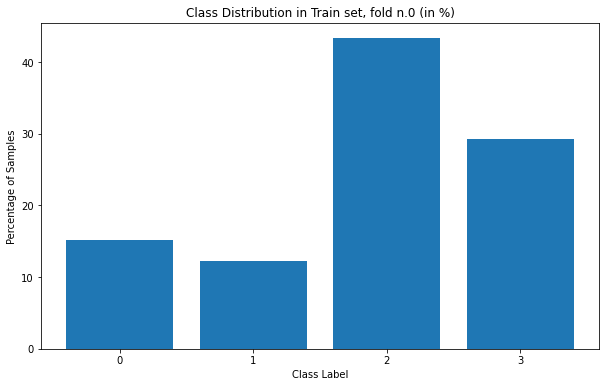

{0: 15, 1: 12, 2: 43, 3: 29}
length val_dataset fold n.0 : 280


280it [00:04, 59.65it/s]


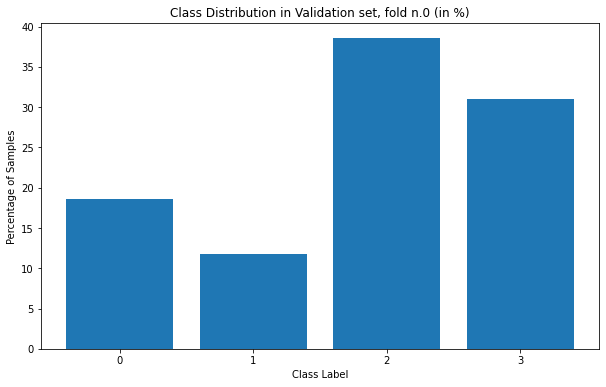

{0: 19, 1: 12, 2: 39, 3: 31}
FOLD 1
--------------------------------
length train_dataset fold n.1 : 1117


1117it [00:18, 60.83it/s]


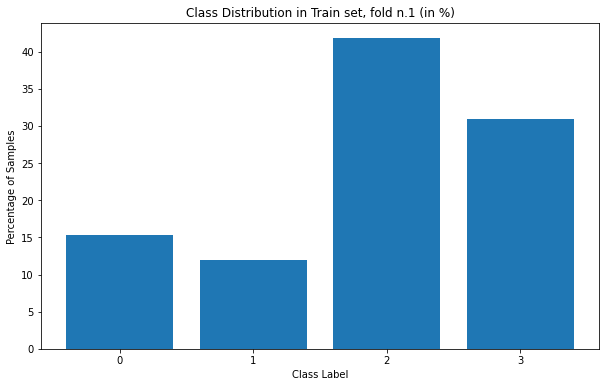

{0: 15, 1: 12, 2: 42, 3: 31}
length val_dataset fold n.1 : 280


280it [00:04, 59.24it/s]


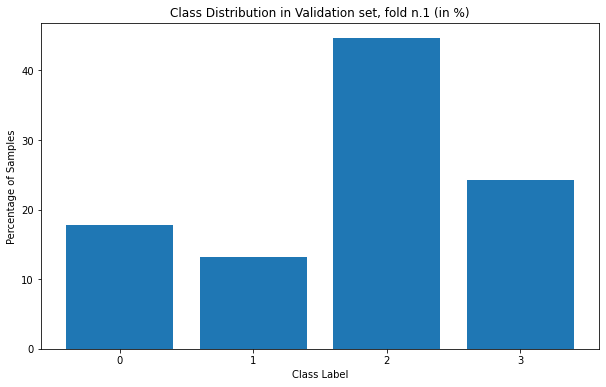

{0: 18, 1: 13, 2: 45, 3: 24}
FOLD 2
--------------------------------
length train_dataset fold n.2 : 1118


1118it [00:18, 60.51it/s]


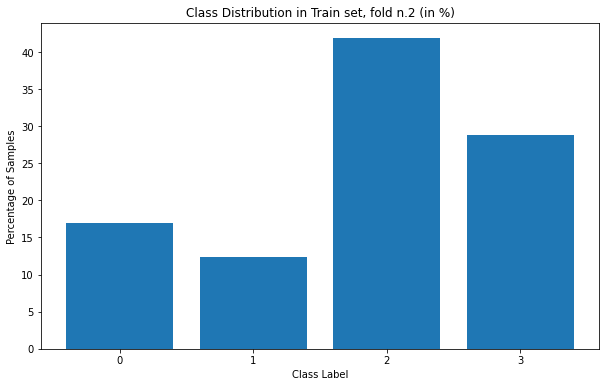

{0: 17, 1: 12, 2: 42, 3: 29}
length val_dataset fold n.2 : 279


279it [00:04, 61.27it/s]


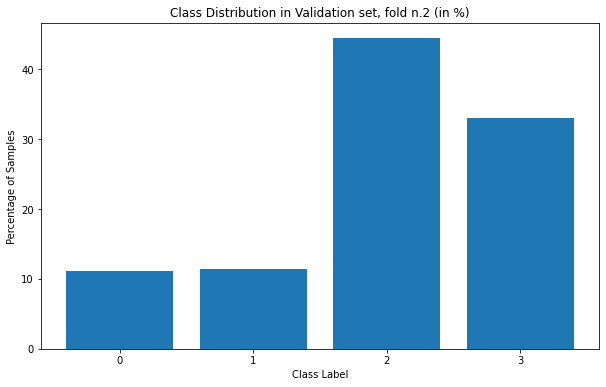

{0: 11, 1: 11, 2: 44, 3: 33}
FOLD 3
--------------------------------
length train_dataset fold n.3 : 1118


1118it [00:18, 59.95it/s]


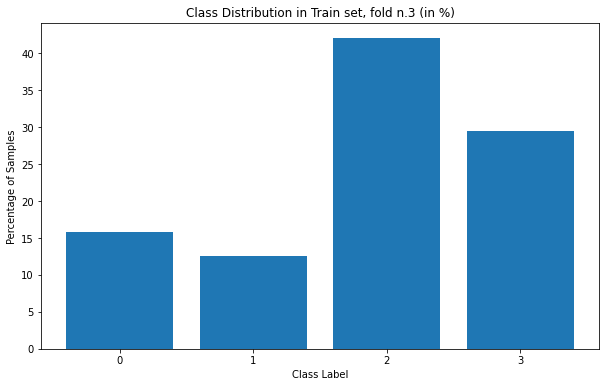

{0: 16, 1: 13, 2: 42, 3: 30}
length val_dataset fold n.3 : 279


279it [00:04, 59.95it/s]


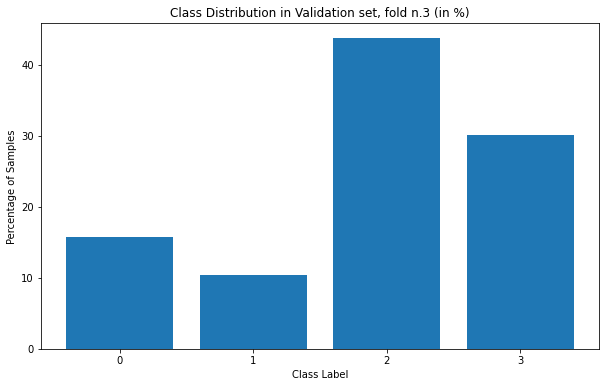

{0: 16, 1: 10, 2: 44, 3: 30}
FOLD 4
--------------------------------
length train_dataset fold n.4 : 1118


1118it [00:19, 58.72it/s]


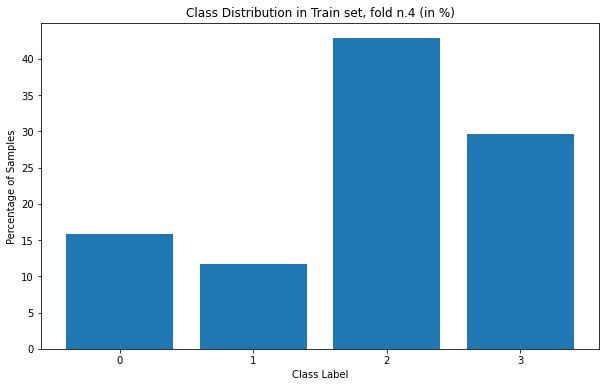

{0: 16, 1: 12, 2: 43, 3: 30}
length val_dataset fold n.4 : 279


279it [00:04, 58.58it/s]


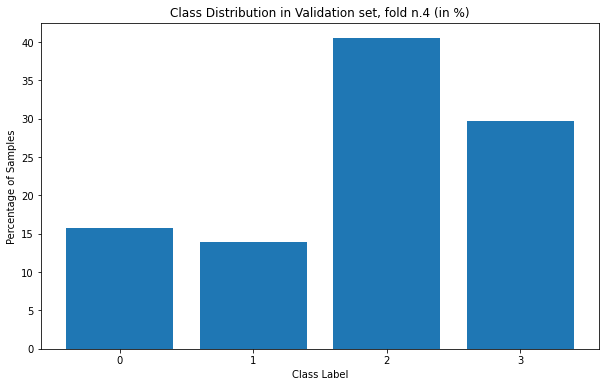

{0: 16, 1: 14, 2: 41, 3: 30}


In [10]:
k_folds = 5
results = {}

# Define the K-Fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)


batch_size = 32


for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.Subset(train_dataset, train_ids)
    val_subsampler = torch.utils.data.Subset(train_dataset, val_ids)
    
   
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      train_subsampler, 
                      batch_size=batch_size)
    valloader = torch.utils.data.DataLoader(
                      val_subsampler,
                      batch_size=batch_size)
    
    train_set = trainloader.dataset
    print(f"length train_dataset fold n.{fold} : {len(trainloader.dataset)}")
    class_distrib(train_set, f"Train set, fold n.{fold}")
    val_set = valloader.dataset
    print(f"length val_dataset fold n.{fold} : {len(valloader.dataset)}")
    class_distrib(val_set, f"Validation set, fold n.{fold}")

1746it [00:30, 57.86it/s]


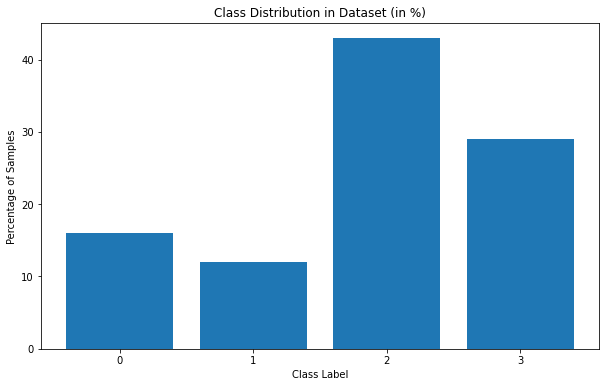

{0: 16, 1: 12, 2: 43, 3: 29}


In [11]:
# Class distribution of the entire dataset

class_distribution_percent, class_weights = class_distrib(dataset, 'Dataset')

In [12]:
# # Check if the dataset is balanced over all the classes in the different subsets

# class_distribution_percent_test, class_weights_test = class_distrib(test_dataset, 'Testing Dataset')
# class_distribution_percent_val, class_weights_val = class_distrib(val_dataset, 'Validation Dataset')
# class_distribution_percent_train, class_weights_train = class_distrib(train_dataset, 'Training Dataset')


In [13]:
# # Convert the class_weights dictionary to a tensor (for the loss)

# class_weights_train_tensor = class_weights_tensor(class_weights_train, device)
# class_weights_test_tensor = class_weights_tensor(class_weights_test, device)
# class_weights_val_tensor = class_weights_tensor(class_weights_val, device)

Dataset train - Number of Samples: 1397
Dataset test - Number of Samples: 349


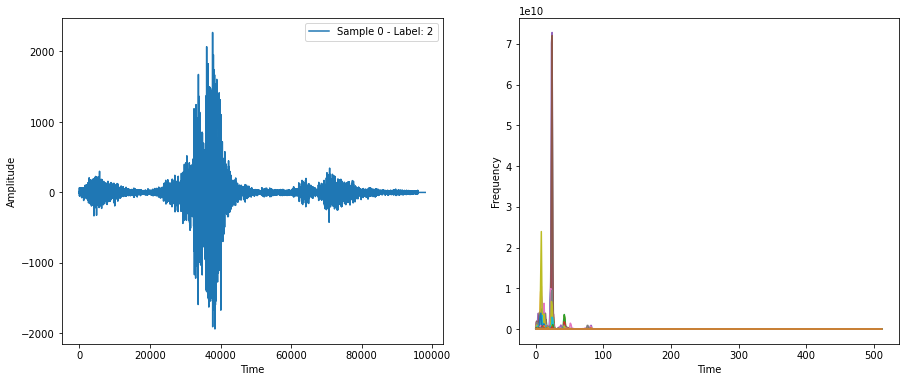

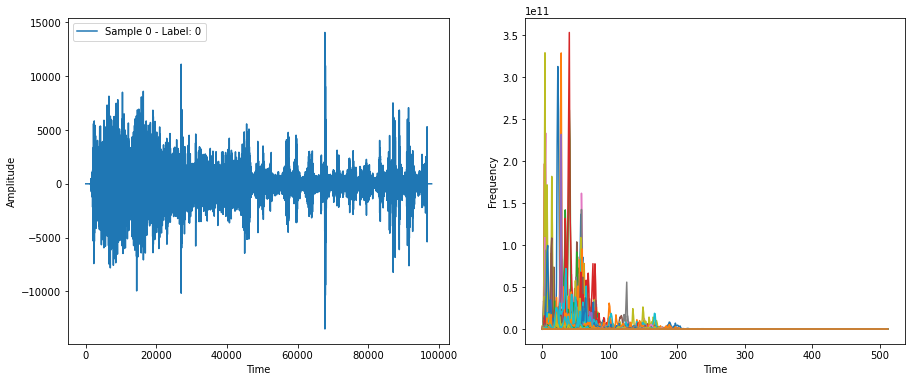

In [14]:
# see what's inside (plot waveforms and mel_spectrograms)
number_of_samples = 1
dataset_names = ["train", "test"]
datasets = [train_dataset, test_dataset]

for dataset, dataset_name in zip(datasets, dataset_names):

    plt.figure(figsize=(15,6))
    print(f"Dataset {dataset_name} - Number of Samples: {len(dataset)}")

    plt.clf()
    plt.title(f"Dataset {dataset_name}")

    ax = plt.subplot(121)
    for i in range(number_of_samples):
        waveform, sample_rate, label, _ = dataset[i]
        ax.plot(waveform.t(), label=f"Sample {i} - Label: {label}")
        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()

    ax = plt.subplot(122)
    for i in range(number_of_samples):
        waveform, sample_rate, label, transform = dataset[i]
        ax.plot(transform.squeeze(), label=f"Sample {i} - Label: {label}")
#        ax.legend()

    plt.xlabel("Time")
    plt.ylabel("Frequency")

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


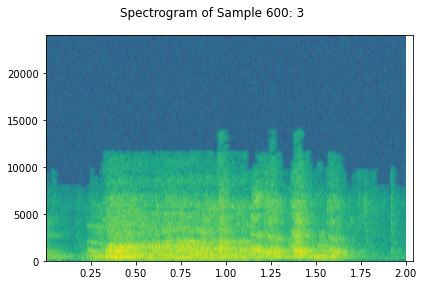

In [15]:
i = 600
waveform, sample_rate, label, _ = train_dataset[i]
plot_specgram(waveform, sample_rate, title=f"Spectrogram of Sample {i}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)

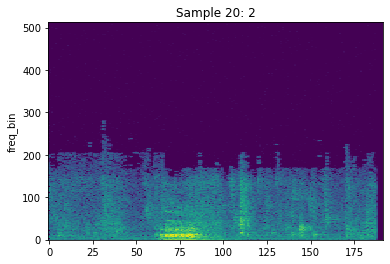

In [16]:
i = 20
waveform, sample_rate, label, _ = train_dataset[i]
plot_spectrogram(torchaudio.transforms.Spectrogram(n_fft=n_fft)(waveform).squeeze(), title=f"Sample {i}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)


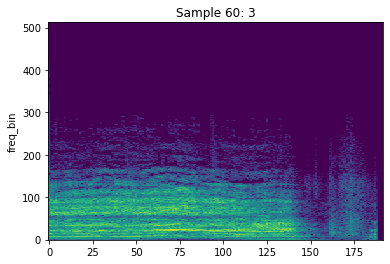

In [17]:
# Same as before
i = 60
waveform, sample_rate, label, spectrogram = train_dataset[i]
plot_spectrogram(spectrogram[0], title=f"Sample {i}: {label}") #'MFCC'
IPython.display.Audio(waveform, rate=sample_rate)


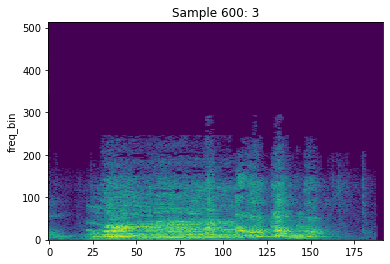

In [18]:
# Same as before
i = 600
waveform, sample_rate, label, spectrogram = train_dataset[i]
plot_spectrogram(spectrogram[0], title=f"Sample {i}: {label}") #'MFCC'
IPython.display.Audio(waveform, rate=sample_rate)


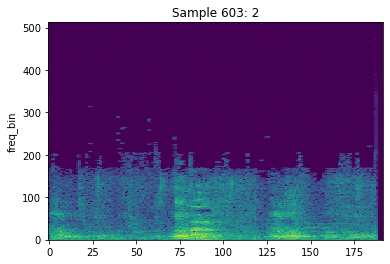

In [19]:
# Same as before
i = 603
waveform, sample_rate, label, spectrogram = train_dataset[i]
plot_spectrogram(spectrogram[0], title=f"Sample {i}: {label}") #'MFCC'
IPython.display.Audio(waveform, rate=sample_rate)


In [38]:
if best_val_loss_overall == float('inf') :
    print('yes')

yes


In [21]:
batch_size = 32
n_epochs = 200
current_datetime = datetime.now()
date_string = current_datetime.strftime("%d.%m.%Y_%H-%M")
saving_path = f'outputs/{transfo_applied}_{n_epochs}_eps_{date_string}.pth'
results = {}
# patience=5
# min_improvement=0.00

best_model_state_overall = None
best_val_loss_overall = float('inf')



print('--------------------------------')

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Create subsets of the train_dataset according to the given list of ids
    train_subset = torch.utils.data.Subset(train_dataset, train_ids)
    val_subset = torch.utils.data.Subset(train_dataset, val_ids)
    
    # Define data loaders for training and testing data in one fold
    trainloader = torch.utils.data.DataLoader(
                      train_subset, 
                      batch_size=batch_size)
    valloader = torch.utils.data.DataLoader(
                      val_subset,
                      batch_size=batch_size)
    
    # Initialize the neural network + losses
    if transfo_applied == 'mel_spectrogram' :
        model = CNN_mel()
    elif transfo_applied == 'mfcc':
        model = CNN_mfcc()
    elif transfo_applied == 'spectrogram':
        model = CNN_spectro()

    train_criterion = nn.CrossEntropyLoss()
    val_criterion = nn.CrossEntropyLoss()

    model.to(device)
    model.apply(reset_weights)
    
    # Initialize optimizer
    optim = torch.optim.Adam(model.parameters(),lr=0.001)

   # Run the training loop for defined number of epochs      
    best_val_loss, best_model_state = train_epochs(model, trainloader, valloader, optim, train_criterion, val_criterion, device, n_epochs, saving_path, fold, best_val_loss_overall, best_model_state_overall, results)

    if best_val_loss_overall == float('inf') :
        best_val_loss_overall = best_val_loss
        best_model_state_overall = best_model_state
    else :
        if best_val_loss < best_val_loss_overall :
        best_val_loss_overall = best_val_loss
        best_model_state_overall = best_model_state
        check = fold
                

# Save the best model state overall after all folds
# needs to be redone bc it saves the best model of the last fold


if best_model_state_overall is not None:
    torch.save(best_model_state_overall, "best_model.pth")


# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

    
# Return the learning curves
#train_losses, train_accuracies, val_losses, val_accuracies

--------------------------------
FOLD 0
--------------------------------
Starting epoch 0
Train Epoch: 0 [0/1117 (0%)]	Loss: 1.404341
Train Epoch: 0 [320/1117 (29%)]	Loss: 1.278381
Train Epoch: 0 [640/1117 (57%)]	Loss: 1.287020
Train Epoch: 0 [960/1117 (86%)]	Loss: 1.200409
epoch n.0 : Average Loss = 1.2125570586749486, Accuracy = 44.58%
epoch n.0 : Val Average Loss = 1.1370269192589655, Val Accuracy = 52.50%
Starting epoch 1
Train Epoch: 1 [0/1117 (0%)]	Loss: 1.285767
Train Epoch: 1 [320/1117 (29%)]	Loss: 0.747060
Train Epoch: 1 [640/1117 (57%)]	Loss: 1.013319
Train Epoch: 1 [960/1117 (86%)]	Loss: 0.898616
epoch n.1 : Average Loss = 0.9817722712244307, Accuracy = 60.79%
epoch n.1 : Val Average Loss = 1.0619423124525282, Val Accuracy = 56.07%
Starting epoch 2
Train Epoch: 2 [0/1117 (0%)]	Loss: 1.069342
Train Epoch: 2 [320/1117 (29%)]	Loss: 0.658227
Train Epoch: 2 [640/1117 (57%)]	Loss: 0.930968
Train Epoch: 2 [960/1117 (86%)]	Loss: 0.996226
epoch n.2 : Average Loss = 0.8941641824586051

epoch n.23 : Val Average Loss = 0.4891257749663459, Val Accuracy = 80.00%
Starting epoch 24
Train Epoch: 24 [0/1117 (0%)]	Loss: 0.397888
Train Epoch: 24 [320/1117 (29%)]	Loss: 0.259657
Train Epoch: 24 [640/1117 (57%)]	Loss: 0.492012
Train Epoch: 24 [960/1117 (86%)]	Loss: 0.479669
epoch n.24 : Average Loss = 0.4278955761875425, Accuracy = 85.05%
epoch n.24 : Val Average Loss = 0.5542212294207679, Val Accuracy = 78.93%
Starting epoch 25
Train Epoch: 25 [0/1117 (0%)]	Loss: 0.430656
Train Epoch: 25 [320/1117 (29%)]	Loss: 0.306237
Train Epoch: 25 [640/1117 (57%)]	Loss: 0.731394
Train Epoch: 25 [960/1117 (86%)]	Loss: 0.463602
epoch n.25 : Average Loss = 0.42672684277806966, Accuracy = 85.14%
epoch n.25 : Val Average Loss = 0.4755128224690755, Val Accuracy = 83.21%
Starting epoch 26
Train Epoch: 26 [0/1117 (0%)]	Loss: 0.365134
Train Epoch: 26 [320/1117 (29%)]	Loss: 0.263209
Train Epoch: 26 [640/1117 (57%)]	Loss: 0.533282
Train Epoch: 26 [960/1117 (86%)]	Loss: 0.408437
epoch n.26 : Average Los

Train Epoch: 47 [960/1117 (86%)]	Loss: 0.256061
epoch n.47 : Average Loss = 0.33375185344900404, Accuracy = 89.17%
epoch n.47 : Val Average Loss = 0.3905429111586677, Val Accuracy = 85.00%
Starting epoch 48
Train Epoch: 48 [0/1117 (0%)]	Loss: 0.359603
Train Epoch: 48 [320/1117 (29%)]	Loss: 0.349928
Train Epoch: 48 [640/1117 (57%)]	Loss: 0.542964
Train Epoch: 48 [960/1117 (86%)]	Loss: 0.476764
epoch n.48 : Average Loss = 0.3621256615434374, Accuracy = 85.77%
epoch n.48 : Val Average Loss = 0.4183702766895294, Val Accuracy = 83.57%
Starting epoch 49
Train Epoch: 49 [0/1117 (0%)]	Loss: 0.338244
Train Epoch: 49 [320/1117 (29%)]	Loss: 0.229802
Train Epoch: 49 [640/1117 (57%)]	Loss: 0.414930
Train Epoch: 49 [960/1117 (86%)]	Loss: 0.357595
epoch n.49 : Average Loss = 0.35619349011353085, Accuracy = 86.48%
epoch n.49 : Val Average Loss = 0.42768675420019364, Val Accuracy = 84.29%
Starting epoch 50
Train Epoch: 50 [0/1117 (0%)]	Loss: 0.187551
Train Epoch: 50 [320/1117 (29%)]	Loss: 0.349484
Trai

Train Epoch: 18 [0/1117 (0%)]	Loss: 0.341193
Train Epoch: 18 [320/1117 (29%)]	Loss: 0.443113
Train Epoch: 18 [640/1117 (57%)]	Loss: 0.702450
Train Epoch: 18 [960/1117 (86%)]	Loss: 0.690388
epoch n.18 : Average Loss = 0.5485211150986807, Accuracy = 79.14%
epoch n.18 : Val Average Loss = 0.5757130715582106, Val Accuracy = 77.86%
Starting epoch 19
Train Epoch: 19 [0/1117 (0%)]	Loss: 0.409644
Train Epoch: 19 [320/1117 (29%)]	Loss: 0.402136
Train Epoch: 19 [640/1117 (57%)]	Loss: 0.672756
Train Epoch: 19 [960/1117 (86%)]	Loss: 0.658367
epoch n.19 : Average Loss = 0.5298203349113464, Accuracy = 79.50%
epoch n.19 : Val Average Loss = 0.5731744666894277, Val Accuracy = 75.71%
Starting epoch 20
Train Epoch: 20 [0/1117 (0%)]	Loss: 0.638895
Train Epoch: 20 [320/1117 (29%)]	Loss: 0.453675
Train Epoch: 20 [640/1117 (57%)]	Loss: 0.612685
Train Epoch: 20 [960/1117 (86%)]	Loss: 0.682780
epoch n.20 : Average Loss = 0.5429221604551587, Accuracy = 79.05%
epoch n.20 : Val Average Loss = 0.5861145456631979,

epoch n.14 : Val Average Loss = 0.4577227334181468, Val Accuracy = 82.80%
Starting epoch 15
Train Epoch: 15 [0/1118 (0%)]	Loss: 0.467583
Train Epoch: 15 [320/1118 (29%)]	Loss: 0.521915
Train Epoch: 15 [640/1118 (57%)]	Loss: 0.582664
Train Epoch: 15 [960/1118 (86%)]	Loss: 0.541274
epoch n.15 : Average Loss = 0.5536727717944554, Accuracy = 79.52%
epoch n.15 : Val Average Loss = 0.4588088459438748, Val Accuracy = 83.15%
Starting epoch 16
Train Epoch: 16 [0/1118 (0%)]	Loss: 0.590139
Train Epoch: 16 [320/1118 (29%)]	Loss: 0.672972
Train Epoch: 16 [640/1118 (57%)]	Loss: 0.626662
Train Epoch: 16 [960/1118 (86%)]	Loss: 0.540235
epoch n.16 : Average Loss = 0.5717166125774383, Accuracy = 78.71%
epoch n.16 : Val Average Loss = 0.4416155185964372, Val Accuracy = 83.87%
Starting epoch 17
Train Epoch: 17 [0/1118 (0%)]	Loss: 0.458406
Train Epoch: 17 [320/1118 (29%)]	Loss: 0.449032
Train Epoch: 17 [640/1118 (57%)]	Loss: 0.494728
Train Epoch: 17 [960/1118 (86%)]	Loss: 0.511197
epoch n.17 : Average Loss

Train Epoch: 38 [960/1118 (86%)]	Loss: 0.297526
epoch n.38 : Average Loss = 0.3645424904567855, Accuracy = 86.85%
epoch n.38 : Val Average Loss = 0.34485357999801636, Val Accuracy = 87.10%
Starting epoch 39
Train Epoch: 39 [0/1118 (0%)]	Loss: 0.237638
Train Epoch: 39 [320/1118 (29%)]	Loss: 0.421078
Train Epoch: 39 [640/1118 (57%)]	Loss: 0.549624
Train Epoch: 39 [960/1118 (86%)]	Loss: 0.454594
epoch n.39 : Average Loss = 0.4003429936511176, Accuracy = 84.70%
epoch n.39 : Val Average Loss = 0.34614219930436874, Val Accuracy = 87.46%
Starting epoch 40
Train Epoch: 40 [0/1118 (0%)]	Loss: 0.243171
Train Epoch: 40 [320/1118 (29%)]	Loss: 0.381537
Train Epoch: 40 [640/1118 (57%)]	Loss: 0.621071
Train Epoch: 40 [960/1118 (86%)]	Loss: 0.436406
epoch n.40 : Average Loss = 0.39349078791482106, Accuracy = 85.60%
epoch n.40 : Val Average Loss = 0.3404178023338318, Val Accuracy = 88.53%
Starting epoch 41
Train Epoch: 41 [0/1118 (0%)]	Loss: 0.380978
Train Epoch: 41 [320/1118 (29%)]	Loss: 0.426444
Trai

Train Epoch: 12 [0/1118 (0%)]	Loss: 0.715896
Train Epoch: 12 [320/1118 (29%)]	Loss: 0.481292
Train Epoch: 12 [640/1118 (57%)]	Loss: 0.683679
Train Epoch: 12 [960/1118 (86%)]	Loss: 0.612607
epoch n.12 : Average Loss = 0.595855723960059, Accuracy = 75.40%
epoch n.12 : Val Average Loss = 0.6876559058825175, Val Accuracy = 70.97%
Starting epoch 13
Train Epoch: 13 [0/1118 (0%)]	Loss: 0.719713
Train Epoch: 13 [320/1118 (29%)]	Loss: 0.410452
Train Epoch: 13 [640/1118 (57%)]	Loss: 0.567854
Train Epoch: 13 [960/1118 (86%)]	Loss: 0.557222
epoch n.13 : Average Loss = 0.6160256811550685, Accuracy = 76.21%
epoch n.13 : Val Average Loss = 0.6893730031119453, Val Accuracy = 71.68%
Starting epoch 14
Train Epoch: 14 [0/1118 (0%)]	Loss: 0.640705
Train Epoch: 14 [320/1118 (29%)]	Loss: 0.338673
Train Epoch: 14 [640/1118 (57%)]	Loss: 0.483974
Train Epoch: 14 [960/1118 (86%)]	Loss: 0.535631
epoch n.14 : Average Loss = 0.569673046043941, Accuracy = 76.74%
epoch n.14 : Val Average Loss = 0.6550338268280029, V

epoch n.8 : Average Loss = 0.6763455407960074, Accuracy = 72.72%
epoch n.8 : Val Average Loss = 0.744231664472156, Val Accuracy = 69.53%
Starting epoch 9
Train Epoch: 9 [0/1118 (0%)]	Loss: 0.546093
Train Epoch: 9 [320/1118 (29%)]	Loss: 0.515720
Train Epoch: 9 [640/1118 (57%)]	Loss: 0.699217
Train Epoch: 9 [960/1118 (86%)]	Loss: 0.807886
epoch n.9 : Average Loss = 0.6659695361341749, Accuracy = 73.35%
epoch n.9 : Val Average Loss = 0.7517028583420647, Val Accuracy = 68.82%
Starting epoch 10
Train Epoch: 10 [0/1118 (0%)]	Loss: 0.492286
Train Epoch: 10 [320/1118 (29%)]	Loss: 0.483599
Train Epoch: 10 [640/1118 (57%)]	Loss: 0.809819
Train Epoch: 10 [960/1118 (86%)]	Loss: 0.700375
epoch n.10 : Average Loss = 0.6638706862926483, Accuracy = 73.17%
epoch n.10 : Val Average Loss = 0.7107929521136813, Val Accuracy = 71.33%
Starting epoch 11
Train Epoch: 11 [0/1118 (0%)]	Loss: 0.463867
Train Epoch: 11 [320/1118 (29%)]	Loss: 0.770221
Train Epoch: 11 [640/1118 (57%)]	Loss: 0.699758
Train Epoch: 11 [

Train Epoch: 32 [640/1118 (57%)]	Loss: 0.601130
Train Epoch: 32 [960/1118 (86%)]	Loss: 0.450554
epoch n.32 : Average Loss = 0.4502422153949738, Accuracy = 83.72%
epoch n.32 : Val Average Loss = 0.40834249059359234, Val Accuracy = 86.02%
Starting epoch 33
Train Epoch: 33 [0/1118 (0%)]	Loss: 0.334107
Train Epoch: 33 [320/1118 (29%)]	Loss: 0.341653
Train Epoch: 33 [640/1118 (57%)]	Loss: 0.590838
Train Epoch: 33 [960/1118 (86%)]	Loss: 0.443473
epoch n.33 : Average Loss = 0.4438972464629582, Accuracy = 83.36%
epoch n.33 : Val Average Loss = 0.4450885487927331, Val Accuracy = 85.30%
Starting epoch 34
Train Epoch: 34 [0/1118 (0%)]	Loss: 0.331403
Train Epoch: 34 [320/1118 (29%)]	Loss: 0.343103
Train Epoch: 34 [640/1118 (57%)]	Loss: 0.550335
Train Epoch: 34 [960/1118 (86%)]	Loss: 0.515679
epoch n.34 : Average Loss = 0.41192420550755093, Accuracy = 85.15%
epoch n.34 : Val Average Loss = 0.4129912339978748, Val Accuracy = 86.02%
Starting epoch 35
Train Epoch: 35 [0/1118 (0%)]	Loss: 0.331495
Train

In [ ]:
# batch_size = 32
# n_epochs = 20
# current_datetime = datetime.now()
# date_string = current_datetime.strftime("%d.%m.%Y_%H-%M")
# saving_path = f'outputs/{transfo_applied}_{n_epochs}_eps_{date_string}.pth'
# patience=5
# min_improvement=0.00

# best_model_state_overall = None


# print('--------------------------------')

# for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
#     print(f'FOLD {fold}')
#     print('--------------------------------')

#     # Sample elements randomly from a given list of ids, no replacement.
#     train_subset = torch.utils.data.Subset(train_dataset, train_ids)
#     val_subset = torch.utils.data.Subset(train_dataset, val_ids)
    
#     # Define data loaders for training and testing data in this fold
#     trainloader = torch.utils.data.DataLoader(
#                       train_subset, 
#                       batch_size=batch_size)
#     valloader = torch.utils.data.DataLoader(
#                       val_subset,
#                       batch_size=batch_size)
    
#     # Init the neural network
#     if transfo_applied == 'mel_spectrogram' :
#         model = CNN_mel()
#     elif transfo_applied == 'mfcc':
#         model = CNN_mfcc()
#     elif transfo_applied == 'spectrogram':
#         model = CNN_spectro()

#     train_criterion = nn.CrossEntropyLoss()
#     val_criterion = nn.CrossEntropyLoss()

#     model.to(device)
#     model.apply(reset_weights)
    
#     # Initialize optimizer
#     optim = torch.optim.Adam(model.parameters(),lr=0.001)


#    # Run the training loop for defined number of epochs      
#     counter = 0
#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []
#     best_val_loss_overall = float('inf')

#     for epoch in range(n_epochs):
        
#         # Print epoch
#         print(f'Starting epoch {epoch}')

#         train_loss, train_accuracy = train_epoch(model, trainloader, optim, train_criterion, device, epoch, train_losses, train_accuracies)

        
#         model.eval()
#         with torch.no_grad():
#             val_loss = 0
#             val_correct = 0
#             val_total = 0
        
#             for i, (wf, sr, labels, transform) in enumerate(valloader):
                
#                 transform, labels = transform.to(device), labels.to(device)
#                 preds = model(transform)
#                 val_loss += val_criterion(preds, labels).item()

#                 _, predicted = preds.max(1)
#                 val_total += labels.size(0)
#                 val_correct += predicted.eq(labels).sum().item()
                
#             average_val_loss = val_loss / len(valloader)
#             val_accuracy = val_correct * 100.0 / val_total 

#             val_losses.append(average_val_loss)
#             val_accuracies.append(val_accuracy)

#             model.train()
            
#             # Check if validation loss has improved
#             if best_val_loss_overall - val_loss > min_improvement:
#                 best_val_loss_overall = val_loss
#                 counter = 0
#                 best_model_state_overall = model.state_dict()
#             else:
#                 counter += 1

#             if counter >= patience:
#                 print("Early stopping! No improvement for", patience, "epochs (fold n.)", fold,".")
#                 break
            
#         print(f"epoch n.{epoch} : Val Average Loss = {average_val_loss}, Val Accuracy = {val_accuracy:.2f}%")



#     correct, total = 0, 0
#     with torch.no_grad():
#         for i, (wf, sr, labels, transform) in enumerate(valloader): 
#             transform, labels = transform.to(device), labels.to(device)
#             preds = model(transform)
#             _, predicted = preds.max(1)
#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()
                

#         # Print accuracy over all fold
#         print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
#         print('--------------------------------')
#         results[fold] = 100.0 * (correct / total)
         


# # Save the best model state overall after all folds
# # needs to be redone bc it saves the best model of the last fold
# if best_model_state_overall is not None:
#     torch.save(best_model_state_overall, "best_model.pth")


# # Print fold results
# print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
# print('--------------------------------')
# sum = 0.0
# for key, value in results.items():
#     print(f'Fold {key}: {value} %')
#     sum += value
# print(f'Average: {sum/len(results.items())} %')


    
# # Return the learning curves
# #train_losses, train_accuracies, val_losses, val_accuracies

In [22]:
# load the hold-out test sample into a DataLoader + define the test loss criterion

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_criterion = nn.CrossEntropyLoss()

In [23]:
# After training, to load the best model for inference or evaluation

state_dict = torch.load("best_model.pth", map_location=device)
best_model.load_state_dict(state_dict)
best_model.to(device)

CNN_spectro(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  

In [30]:
# test on an independant sample :
test_loss, test_accuracy = test_model(best_model, test_dataloader, test_criterion, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:28<00:00,  2.59s/it]


Test set: Average loss: 0.0378, Accuracy: 222/349 (63.6%)

Accuracy by class:
Class 0: 54.24%
Class 1: 0.00%
Class 2: 100.00%
Class 3: 34.78%


In [28]:
# Prediction/Inference on test data

i = random.randint(0,len(test_dataloader.dataset)-1)
input_data = test_dataloader.dataset[i][3].to(device)
target = test_dataloader.dataset[i][2] #.astype(np.int64)

predicted_label, expected_label = predict(best_model, input_data, target)
print(f"Predicted label : {predicted_label}, Expected label : {expected_label}")

Predicted label : 2, Expected label : 2


In [ ]:
# Model summary
input_size = train_dataset[0][3].shape
summary(model, input_size=input_size)

In [ ]:
# try with a random tensor of the right dimensions
model(random_tensor)[0]

In [ ]:
# # train the network

# n_epochs = 20
# current_datetime = datetime.now()
# date_string = current_datetime.strftime("%d.%m.%Y_%H-%M")
# saving_path = f'outputs/{transfo_applied}_{n_epochs}_eps_{date_string}.pth'

# train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(cnn, train_dataloader, val_dataloader, optimizer, train_criterion, val_criterion, device, n_epochs, saving_path)

In [ ]:
# plot learning curves

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.gca().set_facecolor('white')
file_name = f"outputs/losses_{transfo_applied}_{date_string}.png"
plt.savefig(file_name, bbox_inches='tight', pad_inches=0.15,facecolor='white', transparent=False)
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()
plt.gca().set_facecolor('white')
file_name = f"outputs/accuracies_{transfo_applied}_{date_string}.png"
plt.savefig(file_name, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=2)
plt.show()


- Quand faut-il faire de la segmentation ?
- Si nombre de samples =/= (taille d'échant =/=) : trim ou pad, mais on peut aussi stretch ?
- Quand faut-il mieux utiliser une transformation en MelSpectrograms ou en mfcc ?
- Rajouter nn.Dropout() après chaque couche ?
- scheduler ?

- NORMALISATION / BATCH NORMALISATION ?